# Separating A Capella Songs into their Separated Vocal Tracks

One A Capella song is usually made up by 5-8 singers singing their respective parts together to form mainly the bass, tenor, alto, soprano and lead_vocal. At times, there may also be other vocal percussions. 

In this notebook, we aim to **train our own Machine Learning Model** to **separate these 5 main tracks** from one another, given an A Capella song audio input. We will be using a dataset with Japanese A Capella songs (Ja Capella).

In [1]:
import glob
import zipfile
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

In [2]:
with zipfile.ZipFile("./Dataset/Jacappella.zip", 'r') as zip_ref:
        zip_ref.extractall("./Dataset/Jacapella")

In [3]:
df = pd.read_csv('Dataset/Jacapella/meta.csv')

In [4]:
df.sample(10)

,title_in_en,title_in_ja,lyric_writer,copyright_of_lyric_writer,composer,copyright_of_composer,arranger_in_en,arranger_in_ja,subset,voice_part,singer_id,gender,first_lang
136,kisha,汽車,作詞者不詳,PD,大和田愛羅,PD,Kana Yokoi,横井香菜,reggae,bass,Bs2,male,ja
24,machibouke,待ちぼうけ,北原白秋,PD,山田耕筰,PD,Ako,あ子,jazz,lead_vocal,Vo1,female,ja
128,omochanomaachi,おもちゃのマーチ,海野厚,PD,小田島樹人,PD,Kana Yokoi,横井香菜,reggae,alto,A2,female,ja
29,machibouke,待ちぼうけ,北原白秋,PD,山田耕筰,PD,Ako,あ子,jazz,vocal_percussion,VP1,male,ja
19,akaikutsu,赤い靴,野口雨情,PD,本居長世,PD,Ako,あ子,jazz,soprano,S1,female,ja
131,omochanomaachi,おもちゃのマーチ,海野厚,PD,小田島樹人,PD,Kana Yokoi,横井香菜,reggae,vocal_percussion,VP3,male,ja
7,popura,ポプラ,井上赳,PD,信時潔,PD,Ako,あ子,jazz,soprano,S1,female,ja
207,momotarou,桃太郎,作詞者不詳（文部省唱歌）,PD,岡野貞一,PD,Mika Sato,佐藤美香,neutral,tenor,T4,male,ja
96,kutsuganaru,靴が鳴る,清水かつら,PD,弘田龍太郎,PD,Miwa Nomura,野村美和,popular,lead_vocal,Vo1,female,ja
103,akatonbo,赤とんぼ,三木露風,PD,山田耕筰,PD,Miwa Nomura,野村美和,popular,soprano,S1,female,ja


In [5]:
# Create a dataframe with necessary details
df_audio = df[["title_in_en", "subset", "voice_part", "singer_id", "gender",]]

In [6]:
df_audio.head()

,title_in_en,subset,voice_part,singer_id,gender
0,otamajakushi,jazz,lead_vocal,Vo1,female
1,otamajakushi,jazz,soprano,S1,female
2,otamajakushi,jazz,alto,A1,female
3,otamajakushi,jazz,tenor,T1,male
4,otamajakushi,jazz,bass,Bs1,male


In [7]:
# show the different unique vocal parts in Ja Capella
df_audio['voice_part'].unique()

array(['lead_vocal', 'soprano', 'alto', 'tenor', 'bass',
       'vocal_percussion'], dtype=object)

In [8]:
# Check for any null values
df_audio.isnull().sum()

title_in_en    0
subset         0
voice_part     0
singer_id      0
gender         0
dtype: int64

In [9]:
audio_file_dir = []
for index in df_audio.index:
    title = df_audio.iloc[index,0]
    subset = df_audio.iloc[index,1]
    voice = df_audio.iloc[index,2]
    audio_file_dir.append("Dataset/Jacapella/" + str(subset) + "/" + str(title) + "/" + str(voice) + ".wav")

# Added new column in df_audio to show each audio track's directory
df_audio["audio_file_dir"] = audio_file_dir

df_audio

C:\Users\Kruiseq\AppData\Local\Temp/ipykernel_10208/3661916766.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["audio_file_dir"] = audio_file_dir


,title_in_en,subset,voice_part,singer_id,gender,audio_file_dir
0,otamajakushi,jazz,lead_vocal,Vo1,female,Dataset/Jacapella/jazz/otamajakushi/lead_vocal...
1,otamajakushi,jazz,soprano,S1,female,Dataset/Jacapella/jazz/otamajakushi/soprano.wav
2,otamajakushi,jazz,alto,A1,female,Dataset/Jacapella/jazz/otamajakushi/alto.wav
3,otamajakushi,jazz,tenor,T1,male,Dataset/Jacapella/jazz/otamajakushi/tenor.wav
4,otamajakushi,jazz,bass,Bs1,male,Dataset/Jacapella/jazz/otamajakushi/bass.wav
...,...,...,...,...,...,...
205,momotarou,neutral,soprano,S4,female,Dataset/Jacapella/neutral/momotarou/soprano.wav
206,momotarou,neutral,alto,A3,female,Dataset/Jacapella/neutral/momotarou/alto.wav
207,momotarou,neutral,tenor,T4,male,Dataset/Jacapella/neutral/momotarou/tenor.wav
208,momotarou,neutral,bass,Bs1,male,Dataset/Jacapella/neutral/momotarou/bass.wav


# Data Visualisation

Text(0, 0.5, 'Number of Samples')

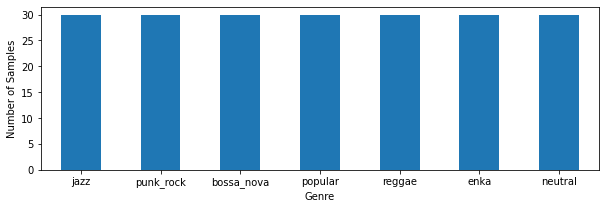

In [10]:
df_audio['subset'].value_counts().plot(kind='bar', figsize=(10,3))
plt.xlabel("Genre")
plt.xticks(rotation=0)
plt.ylabel("Number of Samples")

In [11]:
df_audio.groupby(['subset','voice_part']).count()

title_in_en  singer_id  gender  audio_file_dir
subset     voice_part                                                      
bossa_nova alto                        5          5       5               5
           bass                        5          5       5               5
           lead_vocal                  5          5       5               5
           soprano                     5          5       5               5
           tenor                       5          5       5               5
           vocal_percussion            5          5       5               5
enka       alto                        5          5       5               5
           bass                        5          5       5               5
           lead_vocal                  5          5       5               5
           soprano                     5          5       5               5
           tenor                       5          5       5               5
           vocal_percussion            5          5       5               5
jazz       alto                        5          5       5               5
           bass                        5          5       5               5
           lead_vocal                  5          5       5               5
           soprano                     5          5       5               5
           tenor                       5          5       5               5
           vocal_percussion            5          5       5               5
neutral    alto                        5          5       5               5
           bass                        5          5       5               5
           lead_vocal                  5          5       5               5
           soprano                     5          5       5               5
           tenor                       5          5       5               5
           vocal_percussion            5          5       5               5
popular    alto                        5          5       5               5
           bass                        5          5       5               5
           lead_vocal                  5          5       5               5
           soprano                     5          5       5               5
           tenor                       5          5       5               5
           vocal_percussion            5          5       5               5
punk_rock  alto                        5          5       5               5
           bass                        5          5       5               5
           lead_vocal                  5          5       5               5
           soprano                     5          5       5               5
           tenor                       5          5       5               5
           vocal_percussion            5          5       5               5
reggae     alto                        5          5       5               5
           bass                        5          5       5               5
           lead_vocal                  5          5       5               5
           soprano                     5          5       5               5
           tenor                       5          5       5               5
           vocal_percussion            5          5       5               5

In [12]:
# Add audio time series for each audio track

# audio time series describes the amplitude of the audio at different timesteps.
audio_time_series = []

# sampling rate, sr
sampling_rate = []

for index, data in df_audio.iterrows():
    y, sr = librosa.load(data['audio_file_dir'])
    audio_time_series.append(y)
    sampling_rate.append(sr)

df_audio["audio_time_series"] = audio_time_series
df_audio['sampling_rate'] = sampling_rate

C:\Users\Kruiseq\AppData\Local\Temp/ipykernel_10208/3132904831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["audio_time_series"] = audio_time_series
C:\Users\Kruiseq\AppData\Local\Temp/ipykernel_10208/3132904831.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio['sampling_rate'] = sampling_rate


In [13]:
df_audio

,title_in_en,subset,voice_part,singer_id,gender,audio_file_dir,audio_time_series,sampling_rate
0,otamajakushi,jazz,lead_vocal,Vo1,female,Dataset/Jacapella/jazz/otamajakushi/lead_vocal...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
1,otamajakushi,jazz,soprano,S1,female,Dataset/Jacapella/jazz/otamajakushi/soprano.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
2,otamajakushi,jazz,alto,A1,female,Dataset/Jacapella/jazz/otamajakushi/alto.wav,"[4.5657933e-05, 7.847302e-05, 6.406705e-05, 5....",22050
3,otamajakushi,jazz,tenor,T1,male,Dataset/Jacapella/jazz/otamajakushi/tenor.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
4,otamajakushi,jazz,bass,Bs1,male,Dataset/Jacapella/jazz/otamajakushi/bass.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
...,...,...,...,...,...,...,...,...
205,momotarou,neutral,soprano,S4,female,Dataset/Jacapella/neutral/momotarou/soprano.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
206,momotarou,neutral,alto,A3,female,Dataset/Jacapella/neutral/momotarou/alto.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
207,momotarou,neutral,tenor,T4,male,Dataset/Jacapella/neutral/momotarou/tenor.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
208,momotarou,neutral,bass,Bs1,male,Dataset/Jacapella/neutral/momotarou/bass.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050


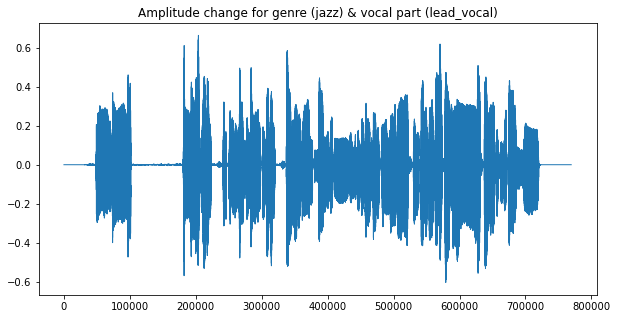

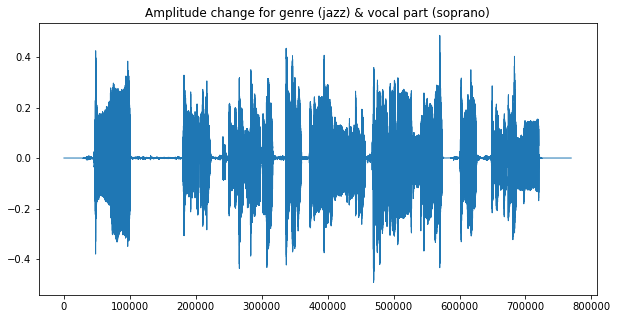

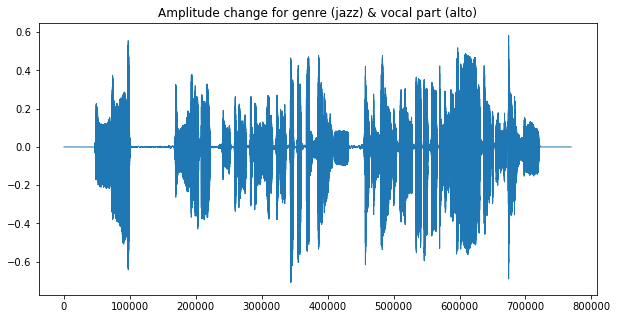

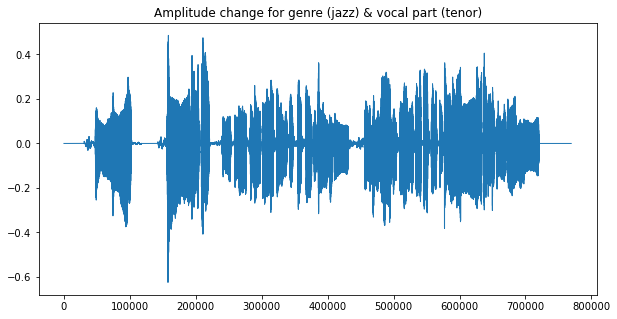

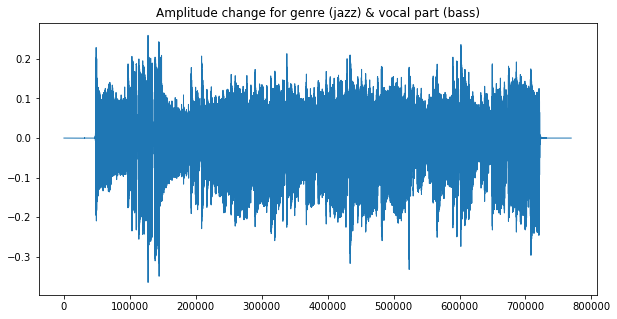

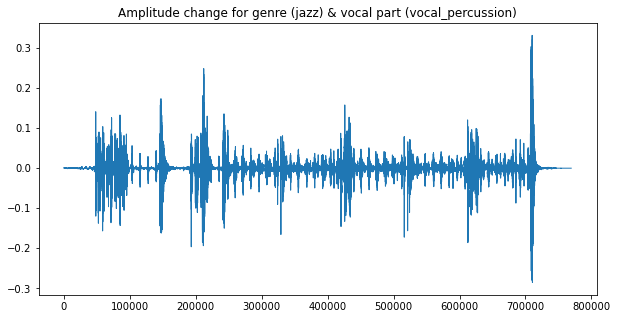

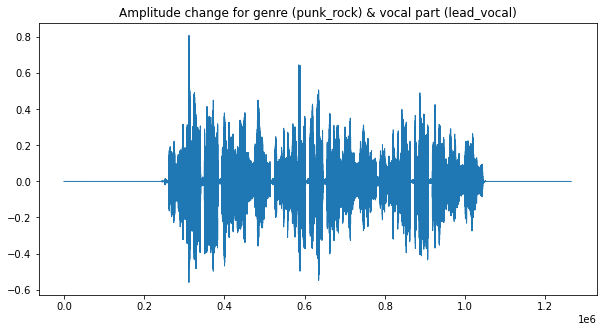

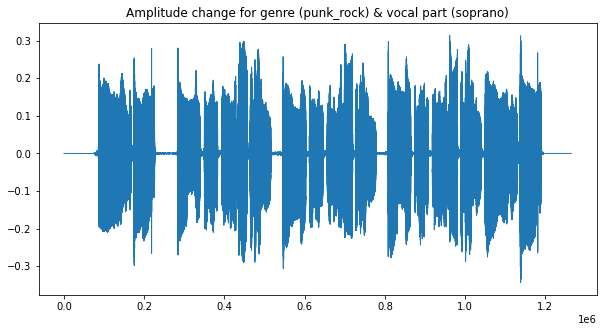

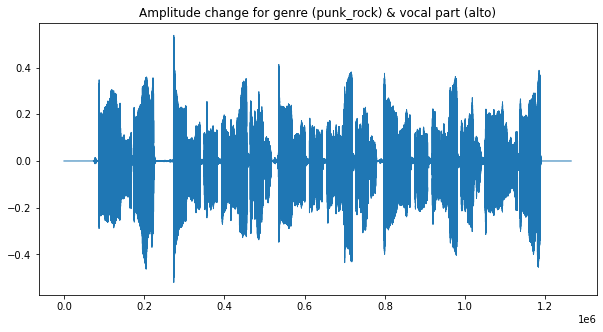

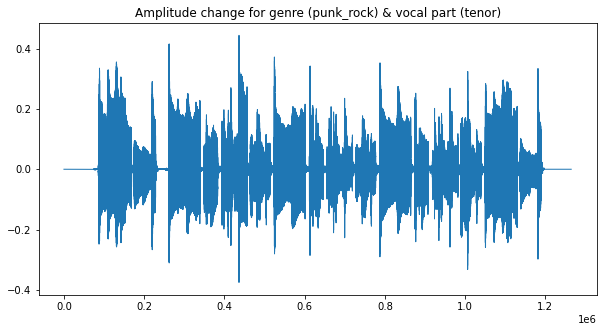

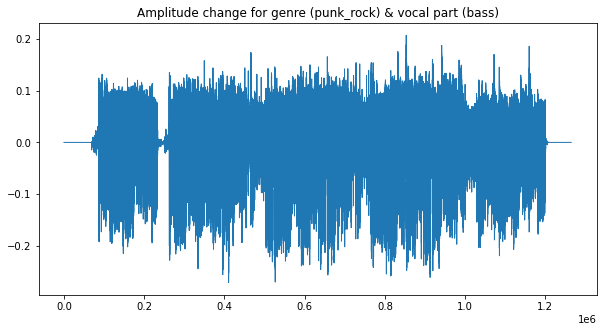

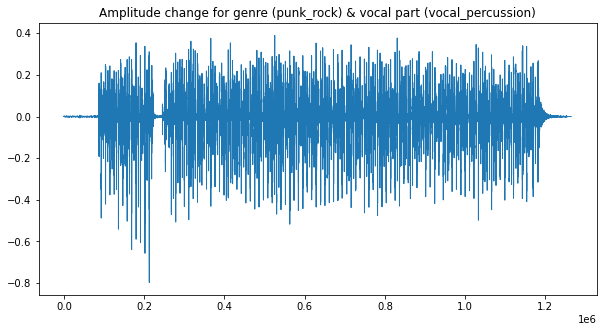

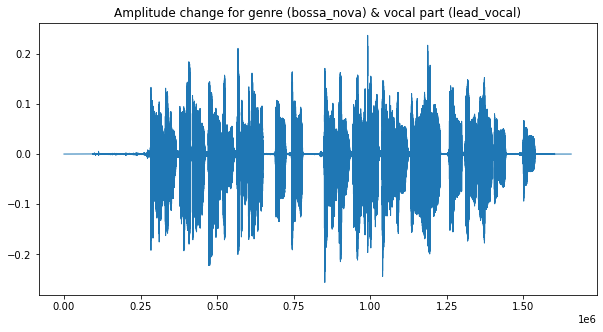

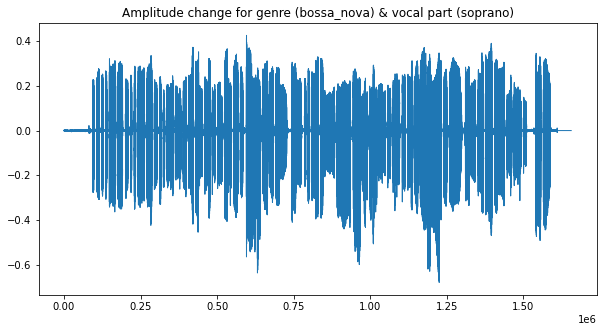

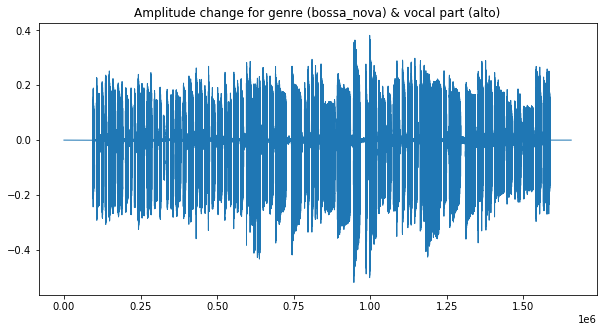

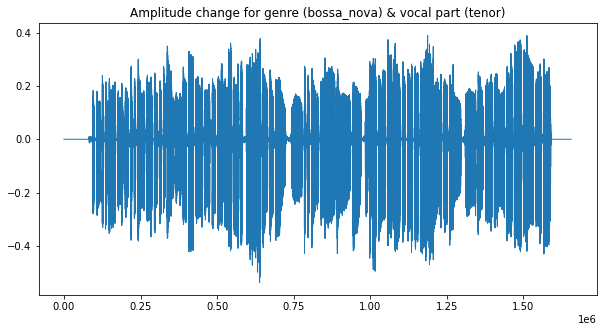

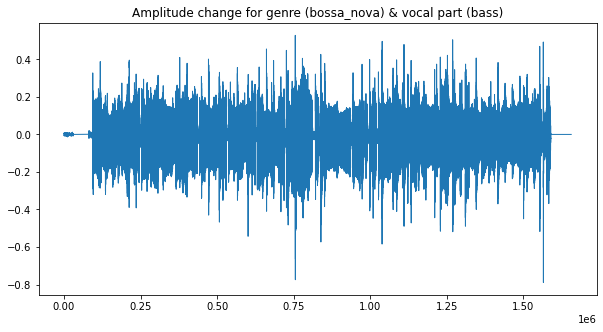

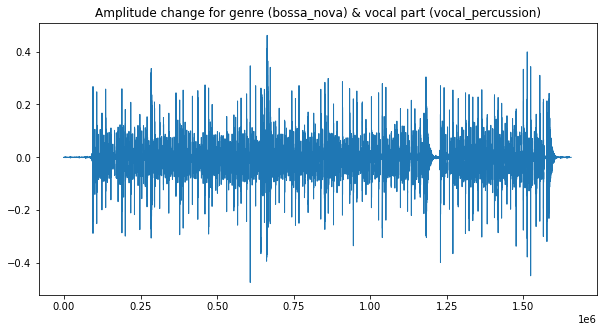

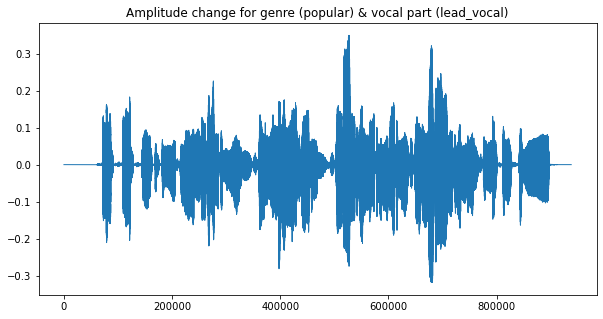

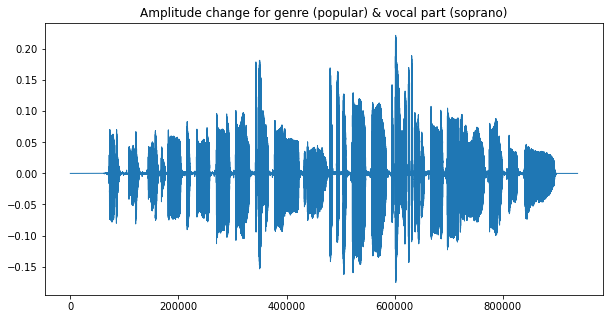

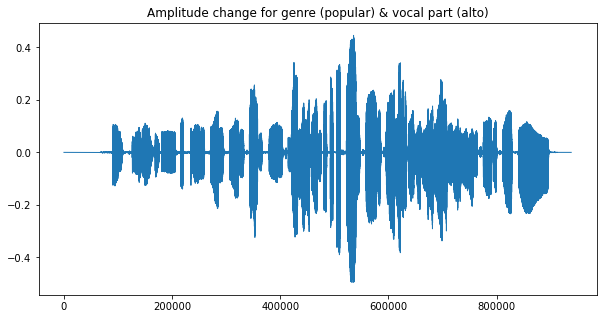

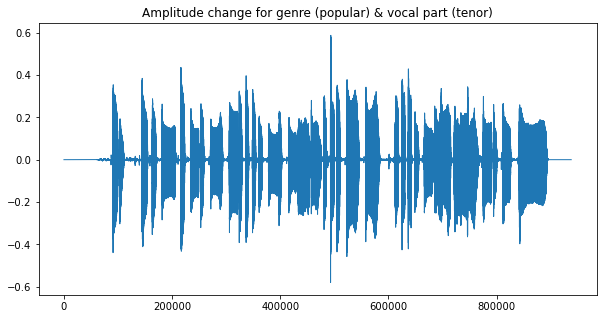

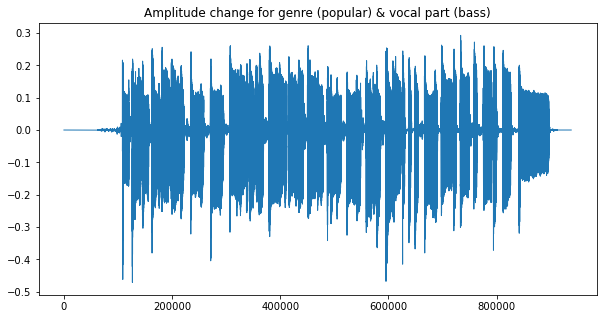

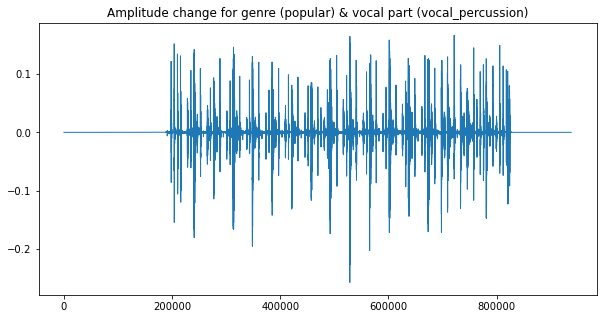

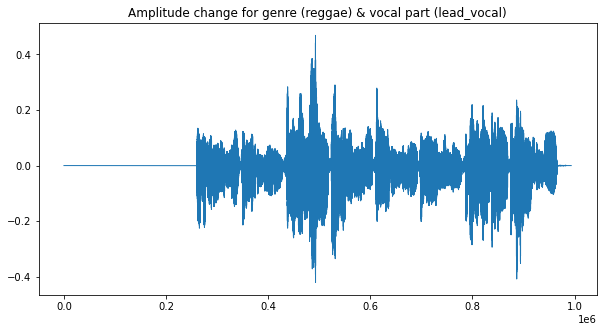

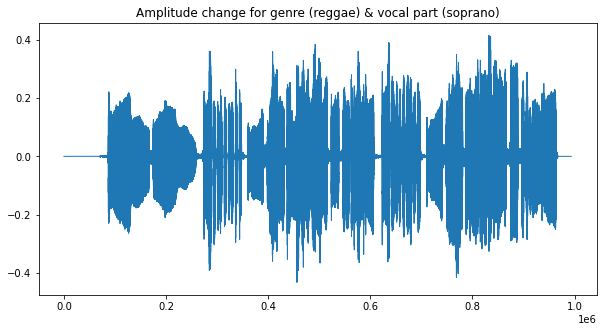

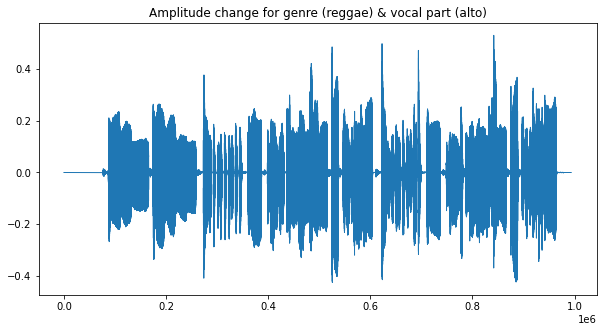

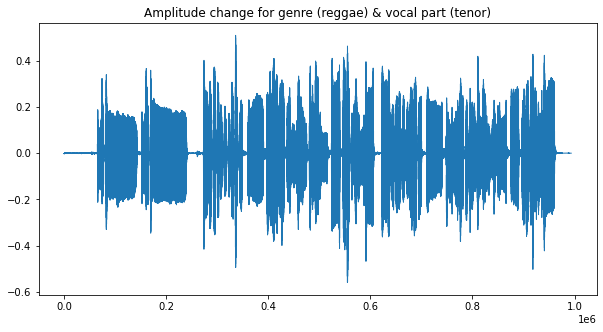

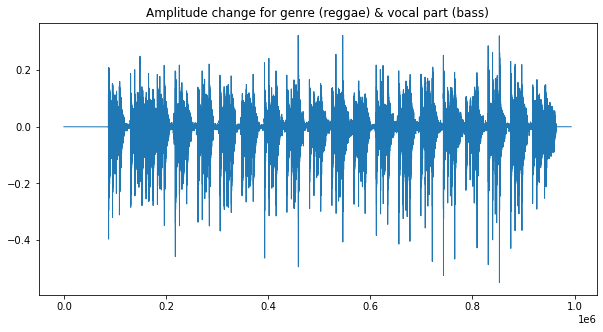

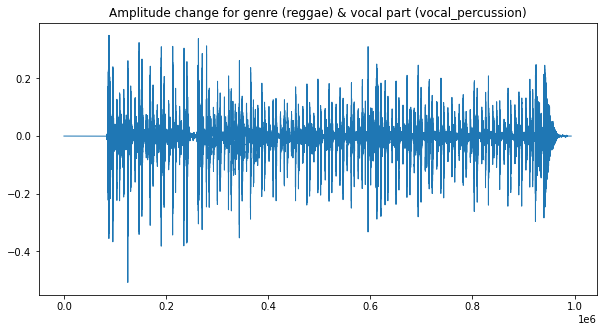

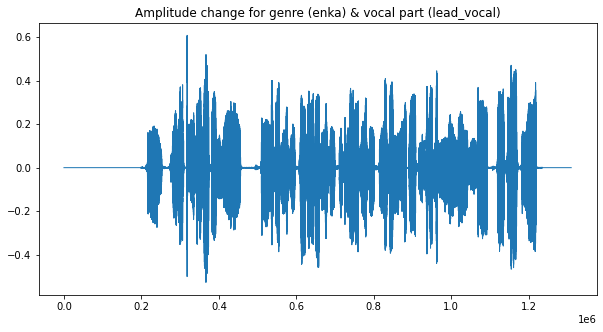

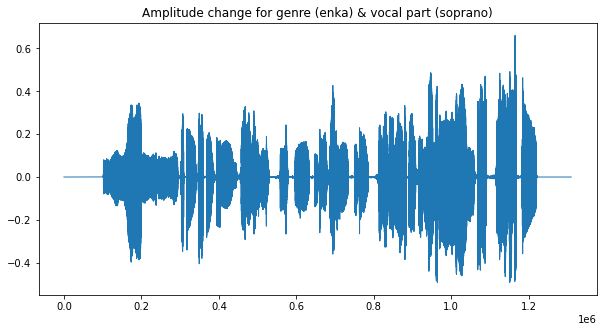

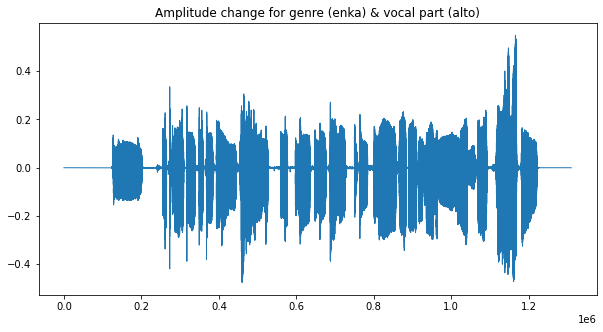

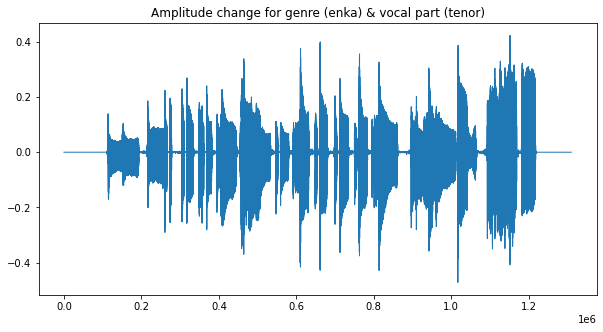

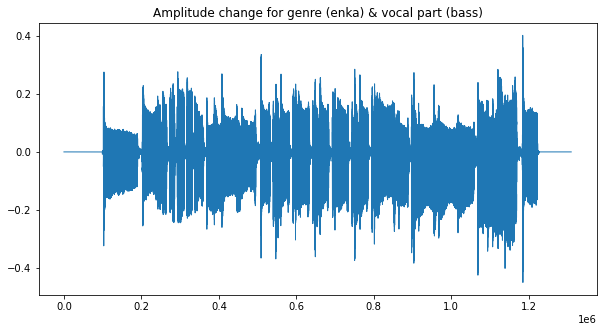

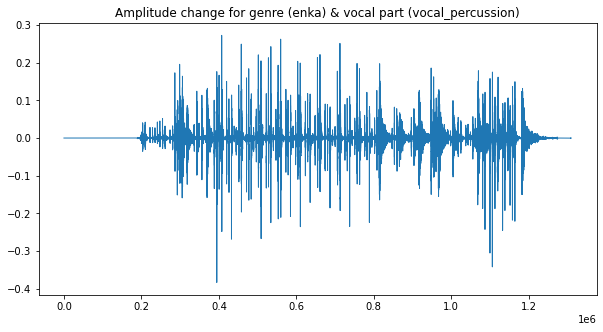

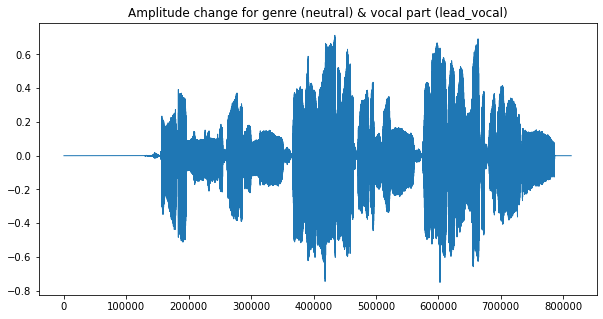

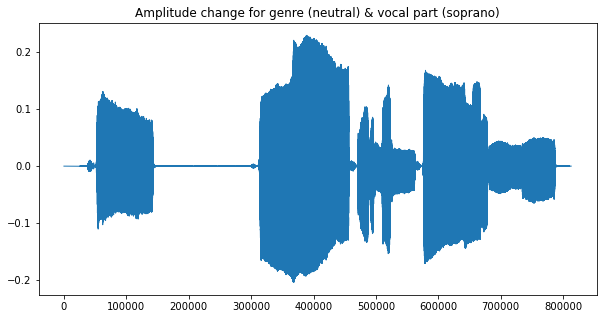

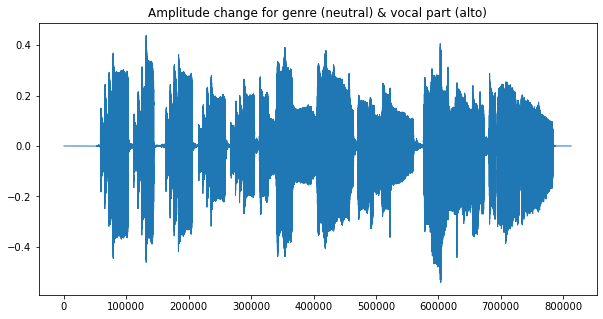

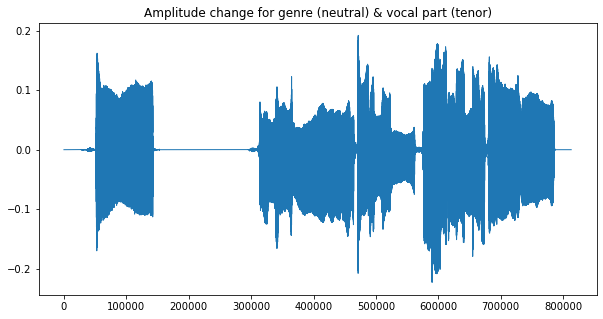

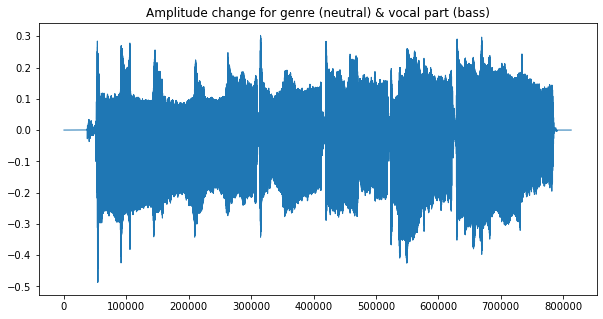

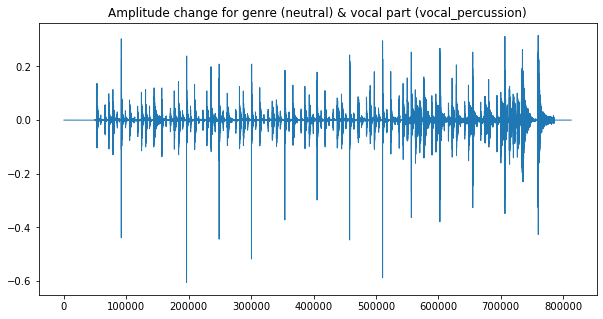

In [14]:
# Visualise Amplitude Change which is the change of pressure near the microphone or recording device 
# for different genre & vocal parts

samples = {"jazz":[], "bossa_nova":[], "enka":[], "neutral":[], "popular":[], "punk_rock":[], "reggae":[]}

for song in df_audio.values:
    if song[2] not in samples[song[1]]:
        samples[song[1]].append(song[2])
        pd.Series(song[6]).plot(figsize=(10, 5), lw=1)
        plt.title(f"Amplitude change for genre ({song[1]}) & vocal part ({song[2]})")
        plt.show()
        

In [15]:
df_audio

,title_in_en,subset,voice_part,singer_id,gender,audio_file_dir,audio_time_series,sampling_rate
0,otamajakushi,jazz,lead_vocal,Vo1,female,Dataset/Jacapella/jazz/otamajakushi/lead_vocal...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
1,otamajakushi,jazz,soprano,S1,female,Dataset/Jacapella/jazz/otamajakushi/soprano.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
2,otamajakushi,jazz,alto,A1,female,Dataset/Jacapella/jazz/otamajakushi/alto.wav,"[4.5657933e-05, 7.847302e-05, 6.406705e-05, 5....",22050
3,otamajakushi,jazz,tenor,T1,male,Dataset/Jacapella/jazz/otamajakushi/tenor.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
4,otamajakushi,jazz,bass,Bs1,male,Dataset/Jacapella/jazz/otamajakushi/bass.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
...,...,...,...,...,...,...,...,...
205,momotarou,neutral,soprano,S4,female,Dataset/Jacapella/neutral/momotarou/soprano.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
206,momotarou,neutral,alto,A3,female,Dataset/Jacapella/neutral/momotarou/alto.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
207,momotarou,neutral,tenor,T4,male,Dataset/Jacapella/neutral/momotarou/tenor.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
208,momotarou,neutral,bass,Bs1,male,Dataset/Jacapella/neutral/momotarou/bass.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050


In [16]:
# EDA on pitch features
# Lists to store pitch analysis results
mean_pitch_list = []
median_pitch_list = []
min_pitch_list = []
max_pitch_list = []

# Function to extract pitch and perform analysis
def extract_pitch_and_analyze(audio_file_path):
    # Load the audio .wav file
    audio_data, sample_rate = librosa.load('./'+ audio_file_path)
    
    # Extract pitch features using the YIN algorithm
    pitch, magnitudes = librosa.piptrack(y=audio_data, sr=sample_rate)
    pitch = pitch[pitch > 0]  # Filter out non-positive pitch values

    # Calculate pitch statistics
    mean_pitch = pitch.mean()
    median_pitch = np.median(pitch)
    min_pitch = pitch.min()
    max_pitch = pitch.max()

    # Append pitch statistics to the respective lists
    mean_pitch_list.append(mean_pitch)
    median_pitch_list.append(median_pitch)
    min_pitch_list.append(min_pitch)
    max_pitch_list.append(max_pitch)

    return {
        'audio_file_path': audio_file_path,
        'mean_pitch': mean_pitch,
        'median_pitch': median_pitch,
        'min_pitch': min_pitch,
        'max_pitch': max_pitch
    }

# Apply the function to each audio file in the dataframe
df_audio['pitch_analysis'] = df_audio['audio_file_dir'].apply(extract_pitch_and_analyze)

# Add pitch statistics columns to the dataframe
df_audio['mean_pitch'] = mean_pitch_list
df_audio['median_pitch'] = median_pitch_list
df_audio['min_pitch'] = min_pitch_list
df_audio['max_pitch'] = max_pitch_list

# Display the resulting dataframe
print(df_audio)

      title_in_en   subset        voice_part singer_id  gender  \
0    otamajakushi     jazz        lead_vocal       Vo1  female   
1    otamajakushi     jazz           soprano        S1  female   
2    otamajakushi     jazz              alto        A1  female   
3    otamajakushi     jazz             tenor        T1    male   
4    otamajakushi     jazz              bass       Bs1    male   
..            ...      ...               ...       ...     ...   
205     momotarou  neutral           soprano        S4  female   
206     momotarou  neutral              alto        A3  female   
207     momotarou  neutral             tenor        T4    male   
208     momotarou  neutral              bass       Bs1    male   
209     momotarou  neutral  vocal_percussion       VP4    male   

                                        audio_file_dir  \
0    Dataset/Jacapella/jazz/otamajakushi/lead_vocal...   
1      Dataset/Jacapella/jazz/otamajakushi/soprano.wav   
2         Dataset/Jacapella/jazz/

C:\Users\Kruiseq\AppData\Local\Temp/ipykernel_10208/2572452655.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio['pitch_analysis'] = df_audio['audio_file_dir'].apply(extract_pitch_and_analyze)
C:\Users\Kruiseq\AppData\Local\Temp/ipykernel_10208/2572452655.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio['mean_pitch'] = mean_pitch_list
C:\Users\Kruiseq\AppData\Local\Temp/ipykernel_10208/2572452655.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [17]:
df_audio.groupby(['voice_part'])[['mean_pitch', 'median_pitch','min_pitch','max_pitch']].mean()

,mean_pitch,median_pitch,min_pitch,max_pitch
voice_part,,,,
alto,1399.859253,1110.904419,146.629333,3998.201416
bass,687.744751,387.000824,145.465942,3950.729004
lead_vocal,1826.919922,1645.273560,146.937668,3999.279297
soprano,1497.849487,1221.998901,146.159943,3998.129395
tenor,1243.329224,921.882568,145.892014,3997.247070
vocal_percussion,1993.366455,2044.482910,145.556900,3999.587158


In [18]:
df_audio['voice_part'].unique()

array(['lead_vocal', 'soprano', 'alto', 'tenor', 'bass',
       'vocal_percussion'], dtype=object)

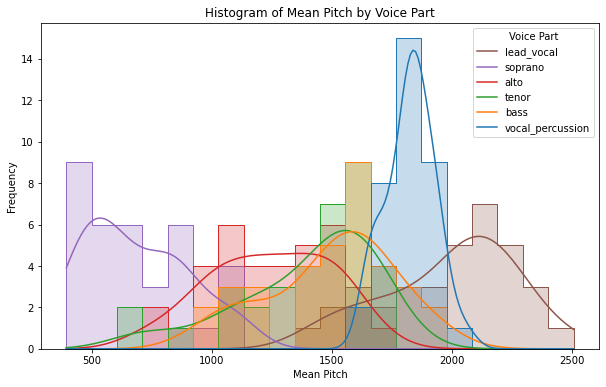

In [19]:
# histogram with hue based on 'voice_part' for mean pitch
plt.figure(figsize=(10, 6))
sns.histplot(data=df_audio, x='mean_pitch', hue='voice_part', element='step', bins=20, kde=True, hue_order=df_audio['voice_part'].unique())
plt.title("Histogram of Mean Pitch by Voice Part")
plt.xlabel("Mean Pitch")
plt.ylabel("Frequency")
plt.legend(title="Voice Part", labels=df_audio['voice_part'].unique())
plt.show()

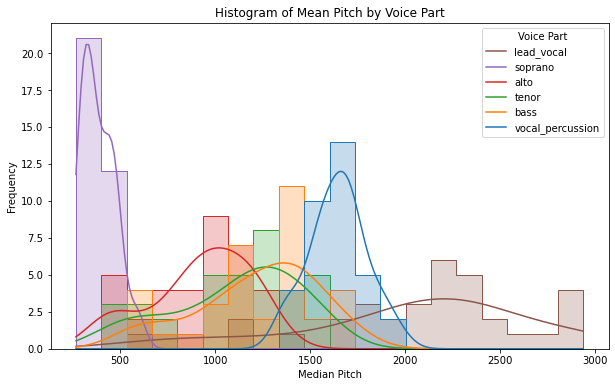

In [20]:
# histogram with hue based on 'voice_part' for mean pitch
plt.figure(figsize=(10, 6))
sns.histplot(data=df_audio, x='median_pitch', hue='voice_part', element='step', bins=20, kde=True, hue_order=df_audio['voice_part'].unique())
plt.title("Histogram of Mean Pitch by Voice Part")
plt.xlabel("Median Pitch")
plt.ylabel("Frequency")
plt.legend(title="Voice Part", labels=df_audio['voice_part'].unique())
plt.show()

In [21]:
# How chroma looks like
def extract_chroma_and_analyze(audio_file_path):
    try:
        # Load the audio .wav file
        audio_data, sample_rate = librosa.load(audio_file_path)

        # Extract Chroma features
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)

        # Visualize the Chroma feature matrix
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
        plt.colorbar()
        plt.title("Chroma Feature for " + audio_file_path)
        plt.xlabel("Time (s)")
        plt.ylabel("Chroma")
        plt.show()

    except Exception as e:
        print(f"Error processing {audio_file_path}: {e}")
# Apply the function to each one folder file in the DataFrame
# for audio_file_path in df_audio['audio_file_dir']:
#     extract_chroma_and_analyze(audio_file_path)

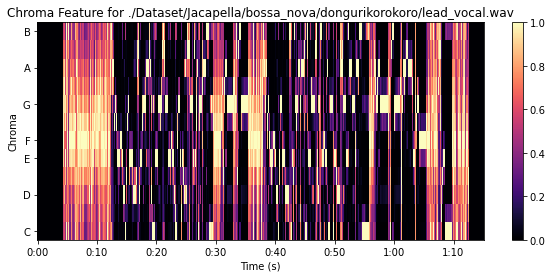

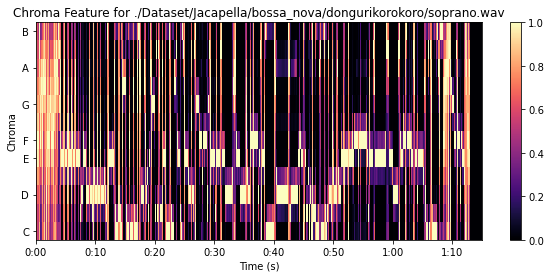

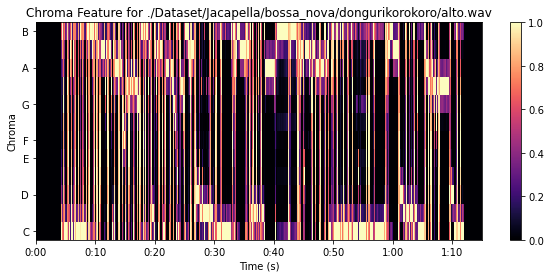

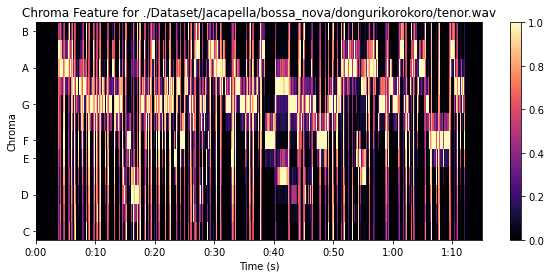

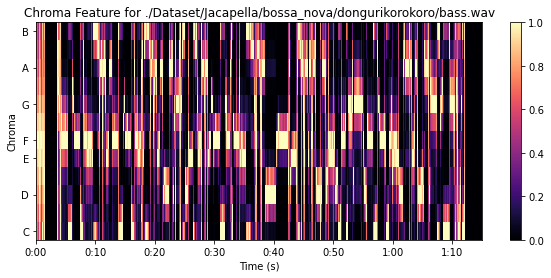

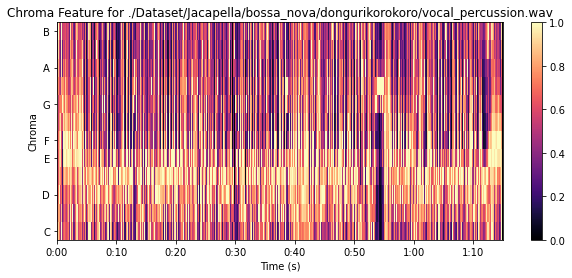

In [26]:
# Apply the function to each one folder file in the DataFrame
path_to_folder = './Dataset/Jacapella/bossa_nova/dongurikorokoro/'
paths = [f"{path_to_folder}{x}.wav" for x in df_audio['voice_part'].unique()]
for audio_file_path in paths:
    extract_chroma_and_analyze(audio_file_path)

In [ ]:
# Attempt to calculate similarity in chroma between genres df_audio['subset'] 
# This was a failure to debug

# from sklearn.metrics.pairwise import cosine_similarity
# import os
# def extract_chroma_features(audio_file_path):
#     audio_data, sample_rate = librosa.load(audio_file_path)
#     chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
#     return chroma


In [40]:
# chroma_features_by_subset = {}

# # Iterate through audio files in the DataFrame
# for subset, group_df in df_audio.groupby('subset'):
#     chroma_features = []
#     file_names = []
    
#     max_columns = 0  # Track the maximum number of columns in Chroma feature matrices
    
#     for _, row in group_df.iterrows():
#         file_path = row['audio_file_dir']
#         chroma = extract_chroma_features(file_path)
#         chroma_features.append(chroma)
#         file_names.append(os.path.basename(file_path))
        
#         # Update the maximum number of columns
#         max_columns = max(max_columns, chroma.shape[1])
    
#     # Pad Chroma feature matrices to have the same number of columns
#     for i in range(len(chroma_features)):
#         chroma = chroma_features[i]
#         if chroma.shape[1] < max_columns:
#             pad_width = max_columns - chroma.shape[1]
#             chroma_features[i] = np.pad(chroma, ((0, 0), (0, pad_width)), mode='constant')
    
#     # Concatenate Chroma feature matrices along the time axis
#     chroma_features = np.concatenate(chroma_features, axis=1)
    
#     # Calculate pairwise cosine similarities
#     cosine_similarities = cosine_similarity(chroma_features)
    
#     # Store the results in the dictionary
#     chroma_features_by_subset[subset] = {
#         'file_names': file_names,
#         'cosine_similarities': cosine_similarities,
#     }

# # Visualize or analyze the similarity results as needed
# for subset, data_dict in chroma_features_by_subset.items():
#     print(f"Subset '{subset}':")
#     file_names = data_dict['file_names']
#     cosine_similarities = data_dict['cosine_similarities']
    
#     # Print the cosine similarity matrix for the subset
#     print("Cosine Similarity Matrix:")
#     print(cosine_similarities)
    
#     # Display audio similarity results
#     for i, filename1 in enumerate(file_names):
#         for j, filename2 in enumerate(file_names):
#             if i < j:
#                 similarity = cosine_similarities[i, j]
#                 print(f"Similarity between {filename1} and {filename2}: {similarity:.4f}")
    

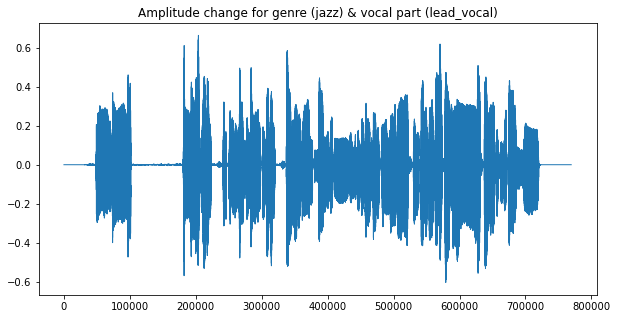

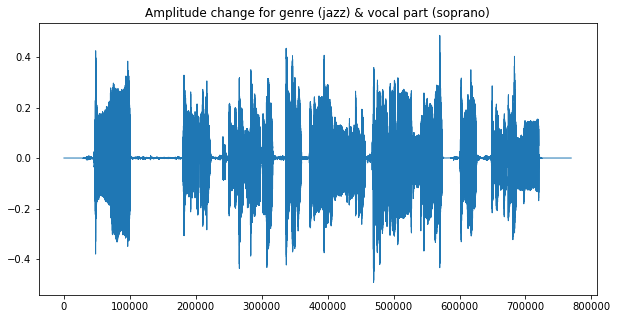

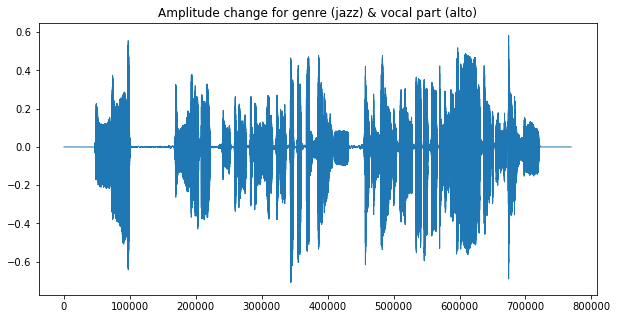

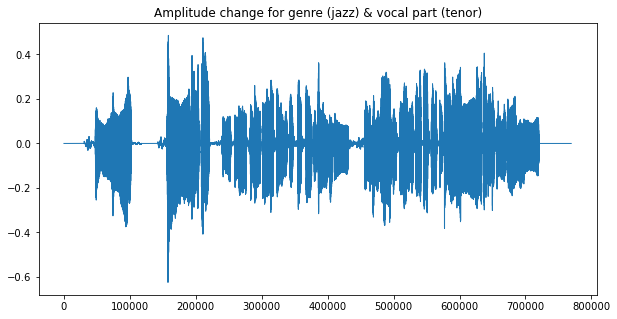

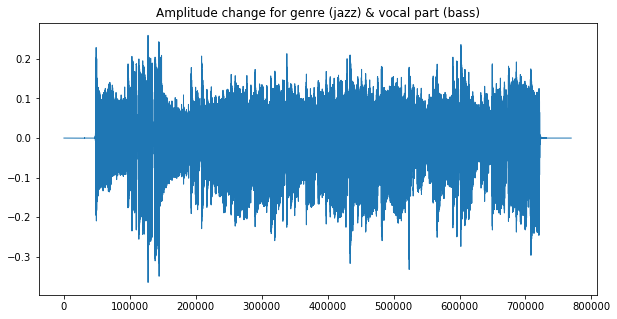

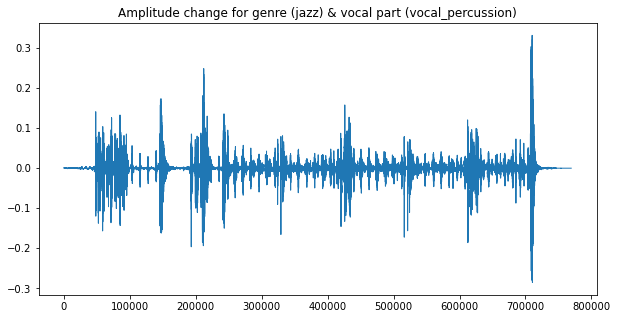

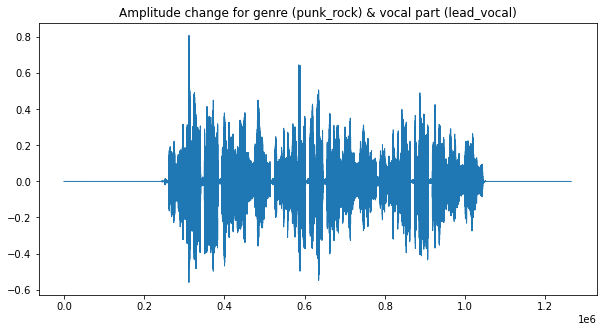

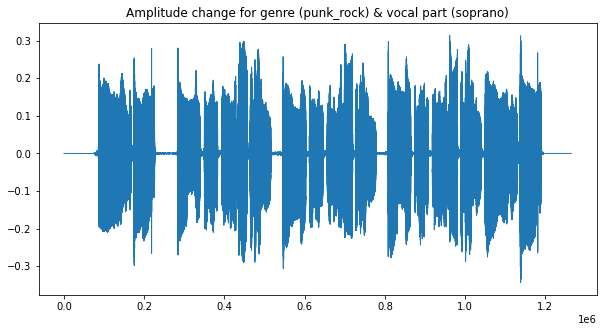

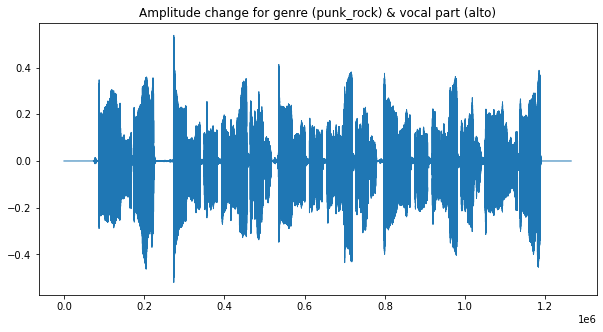

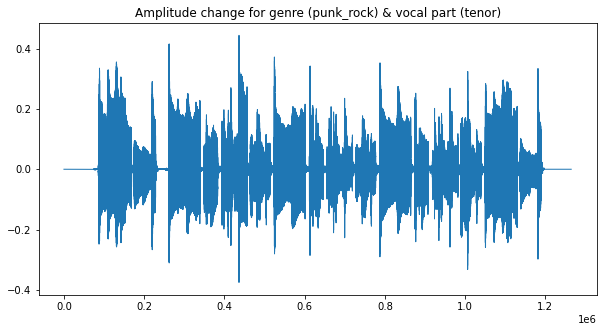

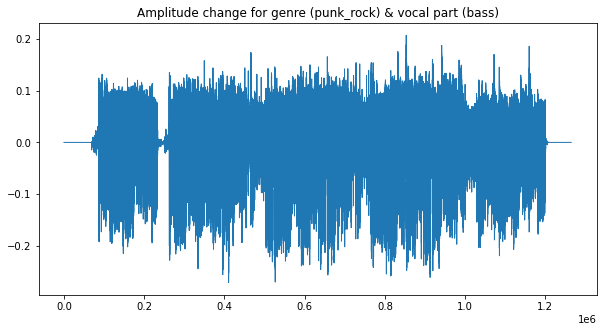

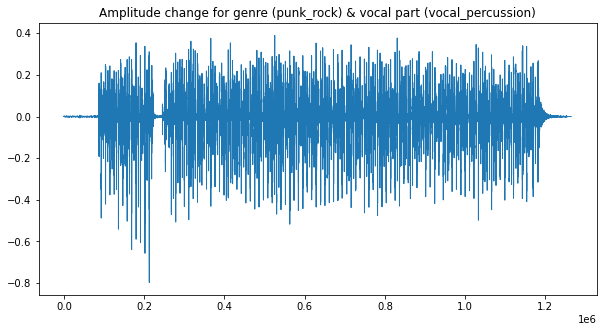

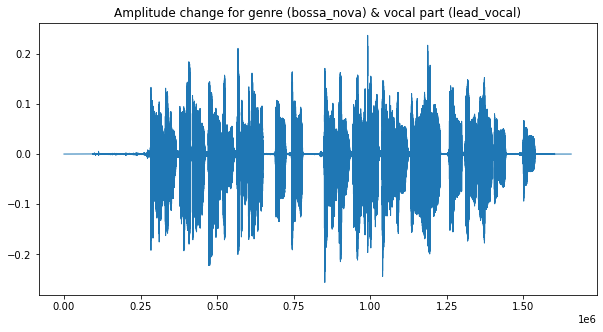

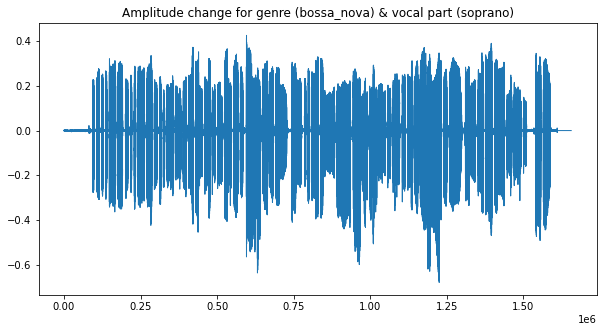

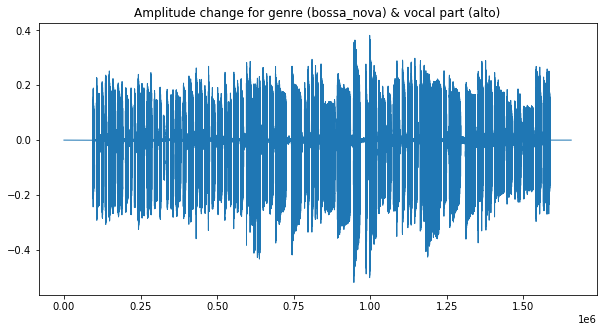

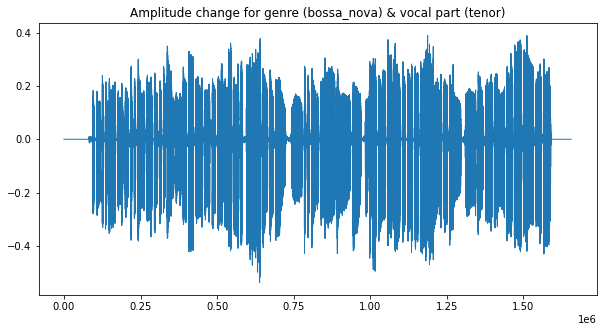

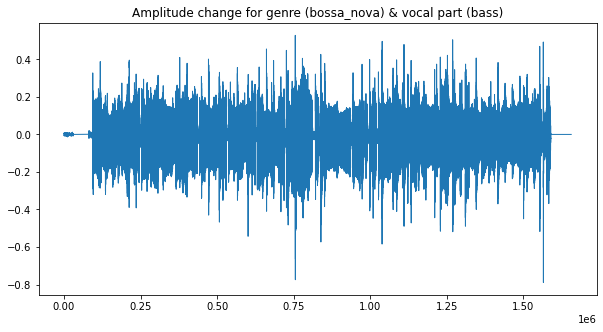

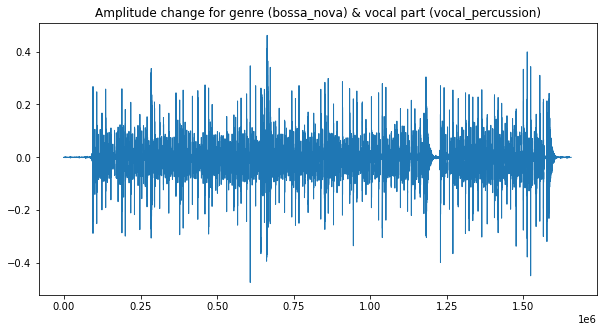

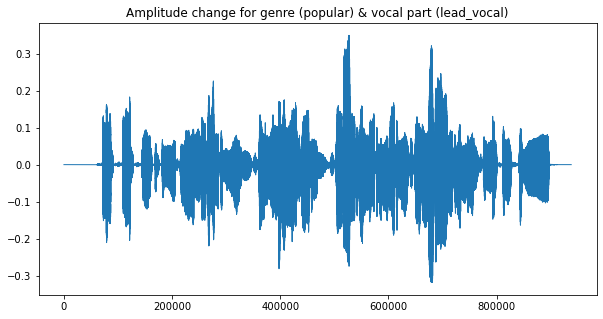

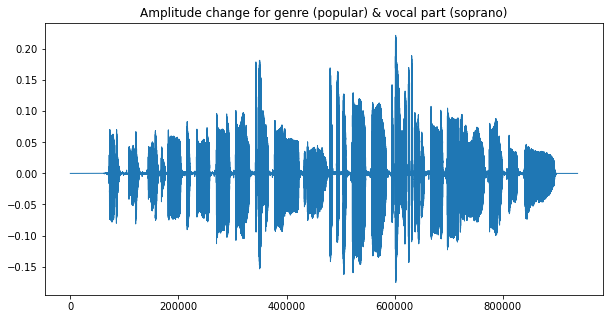

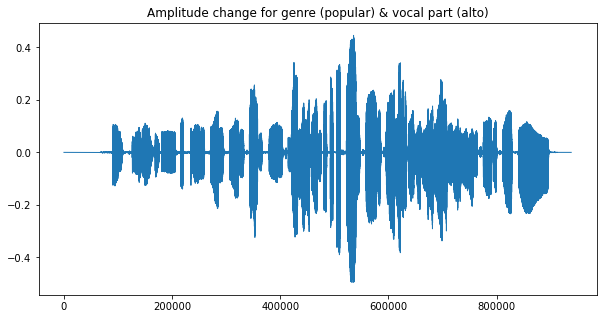

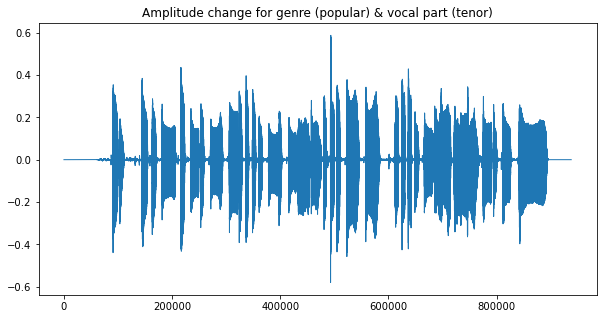

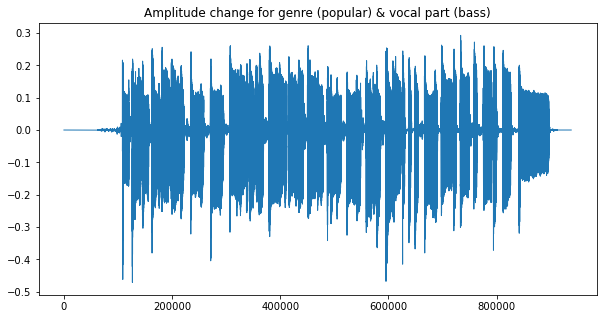

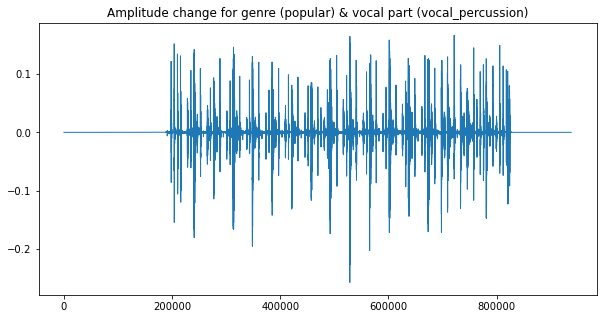

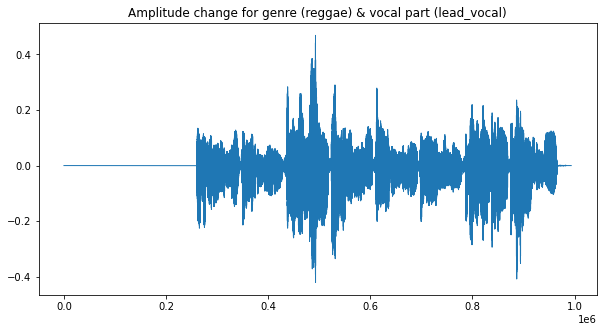

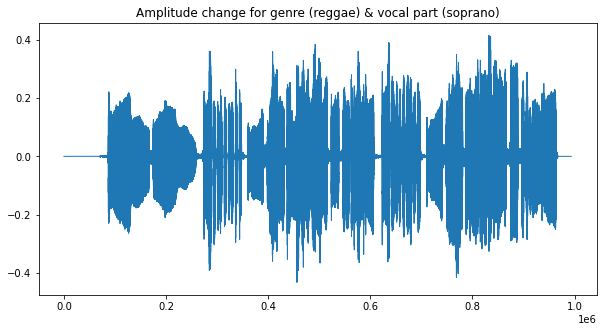

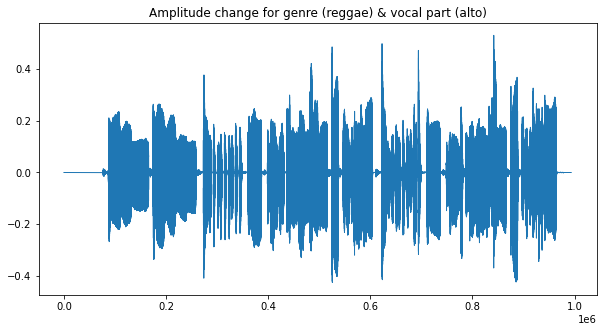

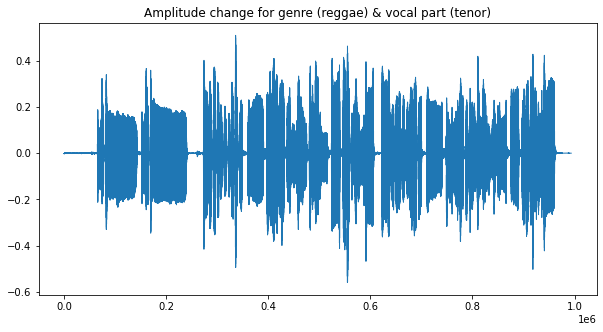

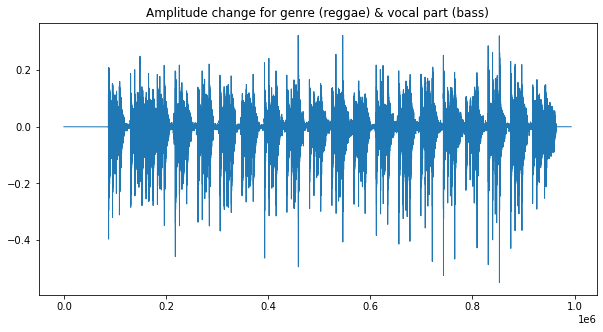

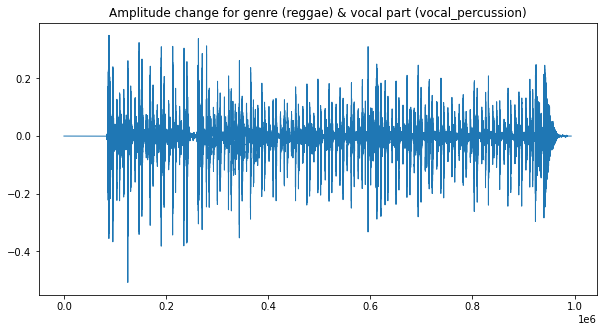

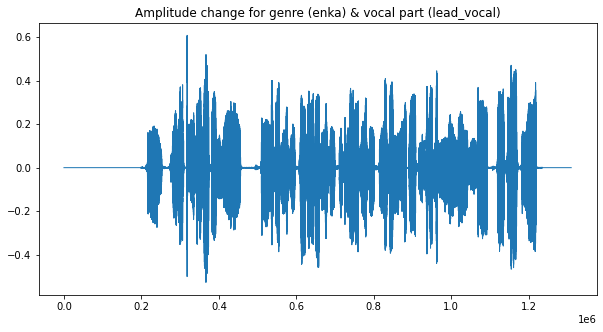

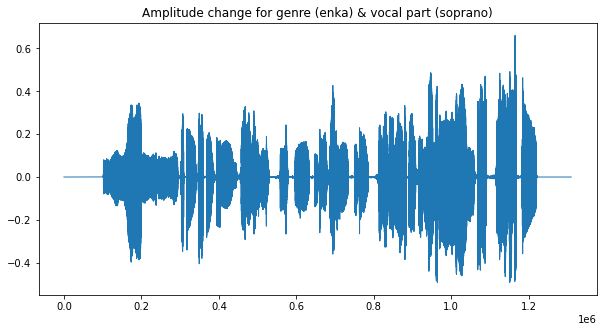

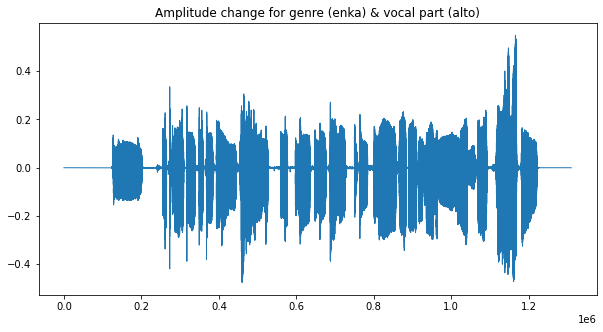

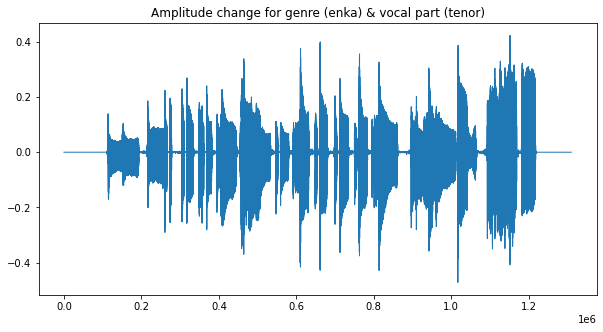

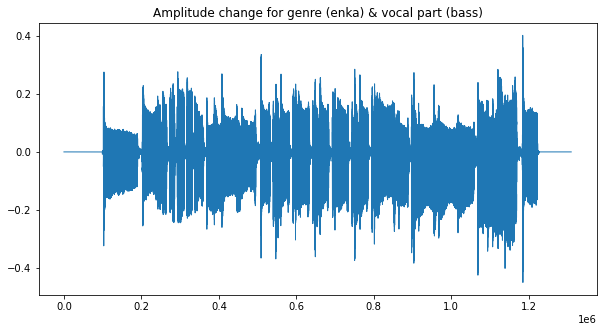

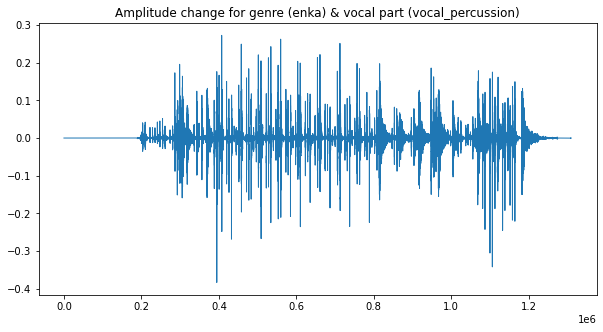

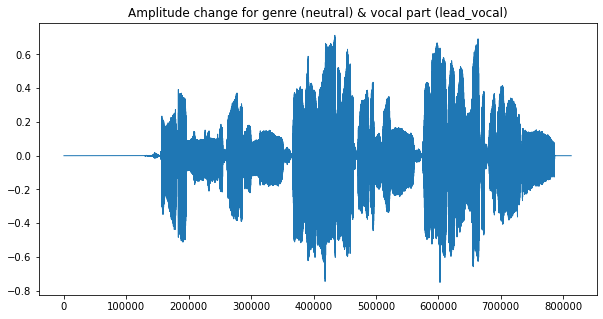

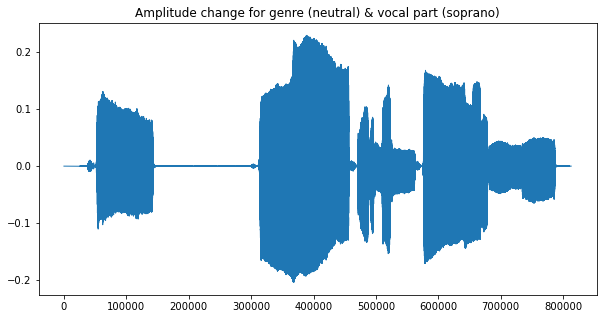

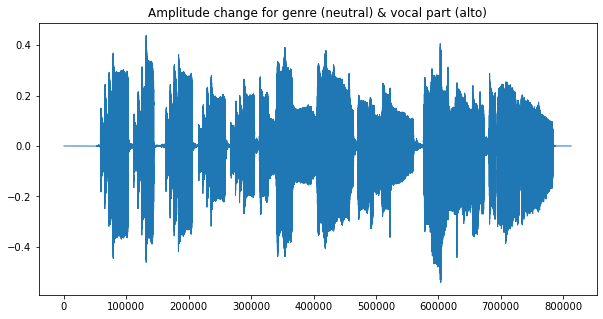

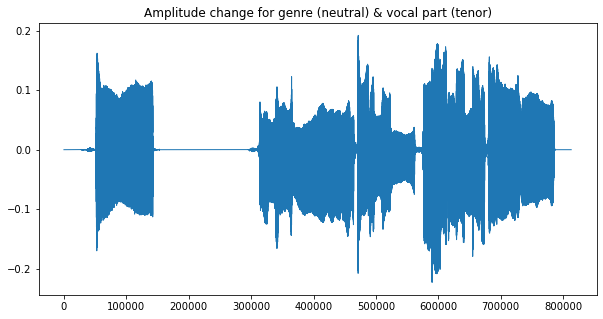

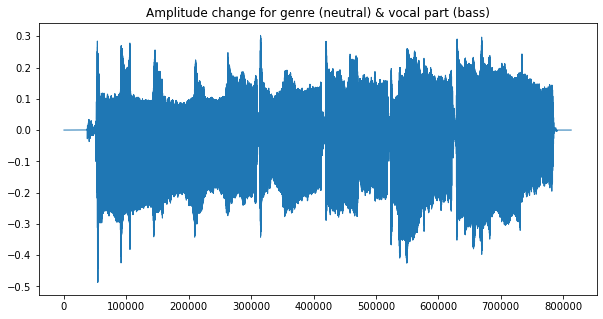

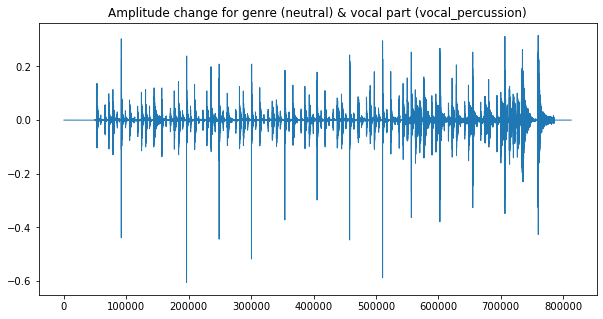

In [41]:
# Visualise Amplitude Change which is the change of pressure near the microphone or recording device 
# for different genre & vocal parts
samples = {"jazz":[], "bossa_nova":[], "enka":[], "neutral":[], "popular":[], "punk_rock":[], "reggae":[]}

for song in df_audio.values:
    if song[2] not in samples[song[1]]:
        samples[song[1]].append(song[2])
        pd.Series(song[6]).plot(figsize=(10, 5), lw=1)
        plt.title(f"Amplitude change for genre ({song[1]}) & vocal part ({song[2]})")
        plt.show()

# Feature Extraction

**1. Zero Crossing Rate (ZCR)**

The zero-crossing rate describes the rate at which a signal moves from positive to zero to negative or from negative to zero to positive. The feature is used in music retrieval systems to identify noisy signals.

ZCR is a feature often used in signal processing and audio analysis. Change in ZCR could be due to transitioning from silence to sound, or change in pitch, or change in environmental sound.

In [42]:
ZCR = []
for song in df_audio.values:
        zero_crossings = librosa.zero_crossings(song[6],pad=False)
        ZCR.append(sum(zero_crossings))

df_audio["zcr"] = ZCR

: 

In [ ]:
# plot 2-D btw voice part & ZCR
df_audio

NameError: name 'df_audio' is not defined